# RMSE-Based Efficiency Evaluation of Synthetic IRT Data

This notebook evaluates the efficiency of synthetic student data for Item Response Theory (IRT) difficulty estimation using Root Mean Square Error (RMSE) as the evaluation metric. 

## Purpose

While the correlation-based evaluation measures how well the relative ranking of question difficulties is preserved, RMSE measures the absolute accuracy of the difficulty estimates. This notebook provides a complementary view to the correlation analysis by examining:

1. How accurately can our neural model predict IRT difficulty parameters in absolute terms?
2. How much real student data would be needed to achieve the same level of accuracy?

We use a 2-Parameter Logistic (2PL) IRT model, which estimates both difficulty and discrimination parameters for each question.

## 1. Setup

### 1.1 Import Libraries

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import sys
from sklearn.metrics import mean_squared_error

# Configure matplotlib for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')

# Configure TensorFlow to hide unnecessary warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

### 1.2 Add Modules to Path

We need to ensure that our custom modules can be imported correctly. This cell adds the modules directory to the Python path.

In [2]:
# Add modules directory to Python path
root_dir = os.path.abspath(os.path.dirname(os.getcwd())) 
modules_path = os.path.join(root_dir, 'code', 'modules')

if modules_path not in sys.path:
    sys.path.insert(0, modules_path)
    print(f"Added {modules_path} to Python path")
else:
    print(f"{modules_path} already in Python path")

Added /Users/matias/Projects/capstone-new/code/modules to Python path


### 1.3 Import Local Modules

Import our custom module that implements the 2PL IRT parameter estimation.

In [3]:
# Import local modules
from irt import estimate_irt_2pl_params 

print("Successfully imported local modules")

Successfully imported local modules


### 1.4 Define Constants and Parameters

Set up constants for column names and simulation parameters.

In [7]:
# Column names in our datasets
USER_ID_COL = "user_id"              # Identifier for students/users
QUESTION_ID_COL = "question_id"      # Identifier for questions
CORRECTNESS_COL = "is_correct"       # Binary indicator of response correctness
IRT_DIFFICULTY_COL = "difficulty"    # IRT difficulty parameter column name

# Simulation parameters
NUM_REPETITIONS = 10  # Number of repetitions for each sample size
SAMPLE_SIZES_PCT = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Proportions of total data
MIN_IRT_SAMPLE_SIZE = 200  # Minimum sample size required for stable IRT estimation

## 2. Define Utility Functions

### 2.1 RMSE Calculation

This function calculates the Root Mean Square Error (RMSE) between true and estimated difficulty parameters.

In [4]:
def calculate_rmse(true_difficulty_df, estimated_difficulty_df, question_col, irt_col):
    """
    Calculate RMSE between true and estimated difficulty parameters.
    
    Args:
        true_difficulty_df: DataFrame with ground truth difficulties
        estimated_difficulty_df: DataFrame with estimated difficulties
        question_col: Name of the column containing question IDs
        irt_col: Name of the column containing difficulty parameters
        
    Returns:
        float: RMSE value, or np.nan if calculation is not possible
    """
    # Ensure question_id columns are of the same type for merging
    true_difficulty_df = true_difficulty_df.copy()
    estimated_difficulty_df = estimated_difficulty_df.copy()
    true_difficulty_df[question_col] = true_difficulty_df[question_col].astype(str)
    estimated_difficulty_df[question_col] = estimated_difficulty_df[question_col].astype(str)

    # Merge dataframes on question ID
    merged = pd.merge(
        true_difficulty_df[[question_col, irt_col]],
        estimated_difficulty_df[[question_col, irt_col]],
        on=question_col,
        suffixes=("_true", "_est")
    )
    
    # Verify there's enough data for calculation
    if merged.empty or len(merged) < 2:
        print("Warning: Not enough matching questions (<2) for RMSE calculation.")
        return np.nan

    # Define column names
    true_col = f"{irt_col}_true"
    est_col = f"{irt_col}_est"
    
    # Verify columns exist
    if true_col not in merged.columns or est_col not in merged.columns:
        print(f"Error: Required columns not found after merge: {true_col}, {est_col}")
        return np.nan

    # Remove NaN values
    merged = merged[[true_col, est_col]].dropna()
    if len(merged) < 2:
        print("Warning: Not enough non-NaN pairs (<2) for RMSE calculation.")
        return np.nan
    
    # Check for constant series which would lead to misleading RMSE
    if merged[true_col].nunique() <= 1 or merged[est_col].nunique() <= 1:
        print("Warning: One or both difficulty series are constant. RMSE calculation might be misleading.")
        # If both are constant and equal, RMSE is 0
        if merged[true_col].nunique() <= 1 and merged[est_col].nunique() <= 1 and merged[true_col].iloc[0] == merged[est_col].iloc[0]:
            return 0.0

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(merged[true_col], merged[est_col]))
    return rmse

### 2.2 Path Setup

This function creates a dictionary of paths needed for the analysis.

In [5]:
def setup_paths(run_dir):
    """Set up all file paths needed for the evaluation.
    
    Args:
        run_dir: Path to the directory containing run artifacts
        
    Returns:
        dict: Dictionary of path strings
    """
    # Determine root directory (assumes results/<run_id> structure)
    root_dir = os.path.abspath(os.path.dirname(os.getcwd()))
    
    paths = {
        # Input data paths
        'data_dir': os.path.join(root_dir, "data", "zapien"),
        'run_dir': run_dir,
        
        # Output path for the plot
        'plot_save_path': os.path.join(run_dir, "efficiency_evaluation_correlation.png")
    }
    
    # Derived paths
    paths['answers_file'] = os.path.join(paths['data_dir'], "answers.csv")
    paths['questions_file'] = os.path.join(paths['data_dir'], "questions.csv")
    paths['embeddings_path'] = os.path.join(run_dir, "03_embeddings.pkl")
    paths['holdout_ids_path'] = os.path.join(run_dir, "holdout_ids.csv")
    paths['original_irt_path'] = os.path.join(run_dir, "01_irt_2pl_params.csv")
    paths['model_weights_path'] = os.path.join(run_dir, "models", "final_nn_model.keras")
    paths['qfeat_path'] = os.path.join(run_dir, "02_question_features.csv")
    paths['predicted_irt_file'] = os.path.join(paths['run_dir'], "05_predicted_2pl_params.csv")
    
    return paths

## 3. Load Data

First, we'll specify the run directory and load the necessary data files.

In [6]:
# Specify the run directory (change this to your actual run directory)
# In evaluation.ipynb, Cell 25
RUN_DIRECTORY = "../results_best_model_no_filter/20250509_080218_1PL_no_filter" # CHANGE TO YOUR ACTUAL PATH
paths = setup_paths(RUN_DIRECTORY, 
                    irt_model_type="1pl", 
                    nn_config_name="best_1pl_config_F_no_filter") # Match the config used

# Set up paths
paths = setup_paths(RUN_DIRECTORY)
print(f"🚀 Starting RMSE Efficiency Evaluation for run: {RUN_DIRECTORY}")

TypeError: setup_paths() got an unexpected keyword argument 'irt_model_type'

In [26]:
# Load data files
print("🔄 Loading data...")

# Load student answers
answers_df = pd.read_csv(paths['answers_file'])
print(f"Loaded {len(answers_df):,} student answers from {answers_df[USER_ID_COL].nunique():,} users")

# Load holdout question IDs
holdout_ids_df = pd.read_csv(paths['holdout_ids_path'])
holdout_ids = holdout_ids_df[QUESTION_ID_COL].tolist()
print(f"Loaded {len(holdout_ids):,} holdout question IDs")

# Load synthetic difficulty estimates
synthetic_difficulty_df = pd.read_csv(paths['predicted_irt_file'])
print(f"Loaded synthetic difficulty estimates for {len(synthetic_difficulty_df):,} questions")

# Display the first few rows of each dataset
print("\nSample of student answers:")
display(answers_df.head())

print("\nSample of synthetic difficulty estimates:")
display(synthetic_difficulty_df.head())

🔄 Loading data...
Loaded 269,171 student answers from 1,875 users
Loaded 449 holdout question IDs
Loaded synthetic difficulty estimates for 449 questions

Sample of student answers:


,answer_id,is_correct,created_at,user_id,grade_id,grade_name,school_id,school_name,user_level,question_id,guide_id,template_id,student_answer,correct_option_matches,student_answer_matches,student_answer_letter
0,1360283,True,2022-05-01 20:54:38.343078,16464,1866.0,I°A 2022,91.0,Colegio Manuel José Irarrázaval,-2.198802,27281,377707,595,8,True,True,e
1,1597208,True,2023-08-06 22:54:49.689721,52991,2021.0,IV° Sección Única,227.0,San Miguel Arcángel,-0.352279,17311,417138,8571,\begin{Bmatrix}x + y = 1\\ x - y = 1\end{Bmatrix},False,False,NaN
2,1468607,False,2022-09-29 12:15:16.720465,52167,NaN,NaN,NaN,NaN,0.674369,25537,397405,2960,`-69` celsius,True,True,d
3,1333175,True,2022-03-31 02:29:40.801884,16395,1870.0,III°A 2022,91.0,Colegio Manuel José Irarrázaval,1.436341,26175,373644,202,`3^3`,True,True,e
4,1345804,True,2022-04-15 02:57:14.272675,50494,1895.0,IV° Medio 2022,227.0,San Miguel Arcángel,NaN,23834,376487,452,`36/6`,True,True,b



Sample of synthetic difficulty estimates:


,question_id,difficulty,discrimination
0,15658,-0.148066,7.332211
1,15665,0.301819,6.575039
2,15672,-0.902191,4.733662
3,15675,-0.426960,5.649267
4,15692,0.816784,10.660524


### 3.1 Filter Data to Holdout Questions

We'll focus our analysis only on the holdout questions.

In [27]:
# Filter answers to only holdout questions
holdout_ids_str = [str(qid) for qid in holdout_ids]
answers_df[QUESTION_ID_COL] = answers_df[QUESTION_ID_COL].astype(str)
holdout_answers_df = answers_df[answers_df[QUESTION_ID_COL].isin(holdout_ids_str)].copy()

print(f"📊 Holdout set: {len(holdout_ids):,} questions, {len(holdout_answers_df):,} answers")
print(f"from {holdout_answers_df[USER_ID_COL].nunique():,} unique students")

# Check if we have sufficient data for IRT estimation
if holdout_answers_df.empty or holdout_answers_df[USER_ID_COL].nunique() < 2 or holdout_answers_df[QUESTION_ID_COL].nunique() < 2:
    print("Error: Insufficient data in holdout answers after filtering.")
else:
    print("✅ Sufficient data available for IRT estimation.")

📊 Holdout set: 449 questions, 26,119 answers
from 1,712 unique students
✅ Sufficient data available for IRT estimation.


## 4. Calculate Ground Truth Difficulty

Calculate the "ground truth" difficulty parameters using the complete set of holdout answers and a 2PL IRT model.

📊 Calculating ground truth difficulty using complete holdout answer set (2PL)...


Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:00<00:00, 521.46it/s, loss=0.4097, bce=0.4097]


✅ Ground truth difficulty calculated.

Ground Truth Difficulty (2PL) Statistics:
count    449.000000
mean      -0.197094
std        0.538957
min       -1.226674
25%       -0.612382
50%       -0.228345
75%        0.169436
max        1.517872
Name: difficulty, dtype: float64


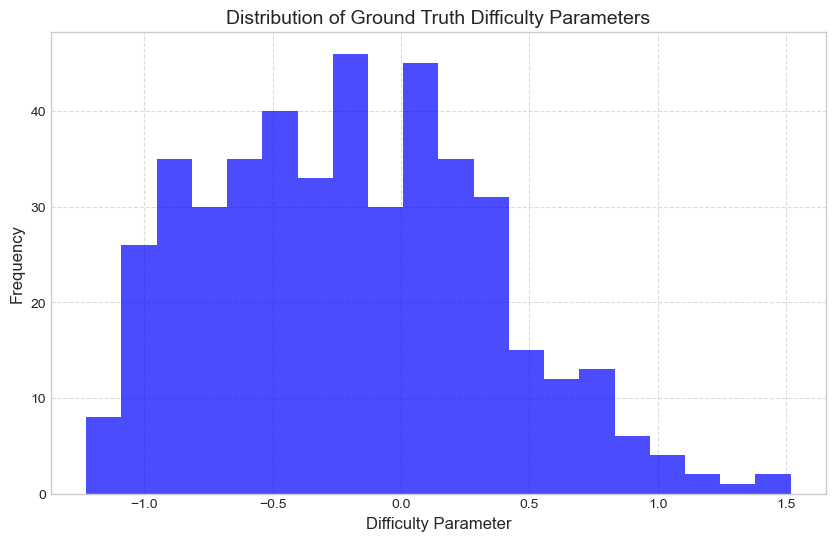

In [28]:
# Calculate ground truth difficulty using 2PL IRT model
print("📊 Calculating ground truth difficulty using complete holdout answer set (2PL)...")

holdout_params_true_df = estimate_irt_2pl_params(
    response_df=holdout_answers_df,
    user_col=USER_ID_COL,
    question_col=QUESTION_ID_COL,
    correctness_col=CORRECTNESS_COL,
    reg_lambda=0.0  # No regularization for ground truth
)

# Extract just the difficulty parameters
ground_truth_difficulty_df = holdout_params_true_df[[QUESTION_ID_COL, IRT_DIFFICULTY_COL]].copy()
print("✅ Ground truth difficulty calculated.")

# Display summary statistics
print("\nGround Truth Difficulty (2PL) Statistics:")
print(ground_truth_difficulty_df[IRT_DIFFICULTY_COL].describe())

# Plot a histogram of the ground truth difficulties
plt.figure(figsize=(10, 6))
plt.hist(ground_truth_difficulty_df[IRT_DIFFICULTY_COL], bins=20, alpha=0.7, color='blue')
plt.title('Distribution of Ground Truth Difficulty Parameters', fontsize=14)
plt.xlabel('Difficulty Parameter', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 5. Calculate RMSE for Synthetic Predictions

Compare the synthetic difficulty estimates to the ground truth by calculating the RMSE.

In [29]:
# Calculate RMSE for synthetic predictions
print("🤖 Calculating RMSE for synthetic predictions...")

synthetic_rmse = calculate_rmse(
    ground_truth_difficulty_df, 
    synthetic_difficulty_df, 
    QUESTION_ID_COL,
    IRT_DIFFICULTY_COL
)

if pd.isna(synthetic_rmse):
    print("Warning: Could not calculate RMSE for synthetic model.")
else:
    print(f"📉 Synthetic Model RMSE: {synthetic_rmse:.4f}")

# Create a comparison visualization
comparison_df = ground_truth_difficulty_df.merge(
    synthetic_difficulty_df,
    on=QUESTION_ID_COL,
    suffixes=('_true', '_synthetic')
)

# Scatter plot of synthetic vs. ground truth difficulties
plt.figure(figsize=(8, 8))
plt.scatter(
    comparison_df[f"{IRT_DIFFICULTY_COL}_true"],
    comparison_df[f"{IRT_DIFFICULTY_COL}_synthetic"],
    alpha=0.6
)
plt.xlabel('Ground Truth Difficulty', fontsize=12)
plt.ylabel('Synthetic Difficulty', fontsize=12)
plt.title(f'Synthetic vs. Ground Truth Difficulty (RMSE = {synthetic_rmse:.4f})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a diagonal reference line
min_val = min(comparison_df[f"{IRT_DIFFICULTY_COL}_true"].min(), 
              comparison_df[f"{IRT_DIFFICULTY_COL}_synthetic"].min())
max_val = max(comparison_df[f"{IRT_DIFFICULTY_COL}_true"].max(), 
              comparison_df[f"{IRT_DIFFICULTY_COL}_synthetic"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.tight_layout()
plt.show()

🤖 Calculating RMSE for synthetic predictions...
📉 Synthetic Model RMSE: 0.3918


ValueError: You are trying to merge on object and int64 columns for key 'question_id'. If you wish to proceed you should use pd.concat

## 6. Simulate Traditional IRT with Varying Real Data

Run a simulation to see how RMSE changes as we vary the amount of real data used for IRT estimation.

In [ ]:
# Simulate traditional IRT with varying data sizes
print("📈 Simulating traditional IRT with varying data sizes (RMSE)...")

# Initialize dictionary to store RMSE values for each sample size
real_data_rmse = {}

# Calculate actual sample sizes based on percentages
max_holdout_answers = len(holdout_answers_df)
actual_sample_sizes = sorted(list(set([
    int(pct * max_holdout_answers) for pct in SAMPLE_SIZES_PCT 
    if int(pct * max_holdout_answers) >= MIN_IRT_SAMPLE_SIZE
])))

# Make sure the full dataset is included if large enough
if max_holdout_answers not in actual_sample_sizes and max_holdout_answers >= MIN_IRT_SAMPLE_SIZE:
    actual_sample_sizes.append(max_holdout_answers)

# Check if we have any valid sample sizes
if not actual_sample_sizes:
    print(f"Warning: No sample sizes large enough (>{MIN_IRT_SAMPLE_SIZE}) for simulation. Check your data.")
else:
    print(f"Sample sizes to test (num answers): {actual_sample_sizes}")

In [ ]:
# Run the simulation for each sample size
if actual_sample_sizes:
    from tqdm.notebook import tqdm
    
    # Use tqdm for a progress bar
    for n_answers in tqdm(actual_sample_sizes, desc="Testing sample sizes"):
        print(f"\nTesting with {n_answers:,} answers ({NUM_REPETITIONS} repetitions)...")
        rep_rmse = []
        
        # Repeat multiple times for statistical stability
        for rep in range(NUM_REPETITIONS):
            # Sample answers (or use full set if sample size is the maximum)
            if n_answers >= len(holdout_answers_df):
                sample_answers_df = holdout_answers_df.copy()
            else:
                sample_answers_df = holdout_answers_df.sample(n=n_answers, random_state=rep)
            
            # Check if the sample has enough diversity for IRT
            if sample_answers_df[USER_ID_COL].nunique() < 2 or sample_answers_df[QUESTION_ID_COL].nunique() < 2:
                print(f"  Skipping Rep {rep+1}: Insufficient unique users/questions in sample.")
                continue
                
            # Estimate IRT parameters using this sample
            estimated_params_df = estimate_irt_2pl_params(
                response_df=sample_answers_df,
                user_col=USER_ID_COL,
                question_col=QUESTION_ID_COL,
                correctness_col=CORRECTNESS_COL,
                reg_lambda=0.0  # No regularization
            )
            
            # Skip if estimation failed
            if estimated_params_df is None or estimated_params_df.empty:
                print(f"  Skipping Rep {rep+1}: IRT estimation returned empty results.")
                continue
                
            # Calculate RMSE between this sample's estimates and ground truth
            rmse = calculate_rmse(
                ground_truth_difficulty_df,
                estimated_params_df,
                QUESTION_ID_COL,
                IRT_DIFFICULTY_COL
            )
            
            # Store valid RMSE values
            if not pd.isna(rmse):
                rep_rmse.append(rmse)
        
        # Calculate average RMSE across repetitions
        if rep_rmse:
            avg_rmse = np.mean(rep_rmse)
            real_data_rmse[n_answers] = avg_rmse
            print(f"  → Average RMSE for {n_answers:,} answers: {avg_rmse:.4f}")
        else:
            print(f"  → No valid RMSE values calculated for {n_answers:,} answers.")
            real_data_rmse[n_answers] = np.nan
            
    # Create a summary table
    print("\nRMSE Summary Table:")
    rmse_df = pd.DataFrame({
        'Sample Size': list(real_data_rmse.keys()),
        'Average RMSE': list(real_data_rmse.values()),
        'Sample %': [n/max_holdout_answers*100 for n in real_data_rmse.keys()]
    }).sort_values('Sample Size')
    
    display(rmse_df.style.format({
        'Sample Size': '{:,.0f}',
        'Average RMSE': '{:.4f}',
        'Sample %': '{:.1f}%'
    }))

## 7. Plot Results and Interpret

Create a visualization to compare the RMSE of the synthetic model against traditional IRT with varying amounts of data.

In [ ]:
# Plot RMSE comparison
print("📊 Plotting RMSE efficiency comparison results...")

# Filter out invalid RMSE values
valid_rmse = {k: v for k, v in real_data_rmse.items() if not pd.isna(v)}

# Check if we have data to plot
if not valid_rmse and pd.isna(synthetic_rmse):
    print("Error: No valid RMSE values to plot.")
else:
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Set default ranges
    if valid_rmse:
        # Convert to numpy arrays for easier manipulation
        x_vals = np.array(list(valid_rmse.keys()))
        y_vals = np.array(list(valid_rmse.values()))
        
        # Sort by x_vals (sample size) for plotting
        sort_indices_x = np.argsort(x_vals)
        x_plot = x_vals[sort_indices_x]
        y_plot = y_vals[sort_indices_x]

        # Plot the real data curve
        plt.plot(x_plot, y_plot, marker='o', linestyle='-', 
                 label="Traditional IRT (Real Data RMSE)", color='#3498db', markersize=6)
        
        min_real_y = np.min(y_vals)
        max_real_y = np.max(y_vals)
        min_x = np.min(x_vals)
        max_x = np.max(x_vals)
    else:
        # Set default ranges if no real data points
        min_real_y, max_real_y = (synthetic_rmse*0.9, synthetic_rmse*1.1) if not pd.isna(synthetic_rmse) else (0,1)
        min_x, max_x = (100, max_holdout_answers)  # Default x range
        x_vals = np.array([])  # Empty arrays
        y_vals = np.array([])
        x_plot = np.array([])
        y_plot = np.array([])

    # Plot the synthetic model RMSE line
    if not pd.isna(synthetic_rmse):
        plt.axhline(y=synthetic_rmse, color='#e74c3c', linestyle='--', linewidth=1.5, 
                    label=f"Synthetic Model RMSE ({synthetic_rmse:.4f})")

    # Calculate intersection point (where synthetic model equals real data)
    intersection_x = np.nan
    intersection_text = ""
    
    if pd.isna(synthetic_rmse):
        intersection_text = "Synthetic RMSE could not be calculated."
    elif len(y_vals) < 2:
        intersection_text = "Not enough real data points for comparison."
    elif synthetic_rmse < min_real_y:
        intersection_text = "Synthetic model outperforms all tested real data samples (RMSE)."
    elif synthetic_rmse > max_real_y:
        intersection_text = "Synthetic model underperforms all tested real data samples (RMSE)."
    else:
        # Interpolate to find equivalence point
        # Sort by y_vals (RMSE) ASCENDING for np.interp
        sort_indices_y = np.argsort(y_vals)
        sorted_y_asc = y_vals[sort_indices_y]
        sorted_x_corr = x_vals[sort_indices_y]

        # Find intersection point
        intersection_x = np.interp(synthetic_rmse, sorted_y_asc, sorted_x_corr)
        intersection_text = f"Equivalent to ~{intersection_x:,.0f} real student answers (RMSE)"
        
        # Plot the intersection line
        plt.axvline(x=intersection_x, color='#2ecc71', linestyle=':', linewidth=1.5, 
                   label=f"Equiv. Real Answers: ~{intersection_x:,.0f}")

    # Style the plot
    plt.xlabel("Number of Real Student Answers Used (Holdout Set)", fontsize=12)
    plt.ylabel("IRT Difficulty Estimation RMSE", fontsize=12)
    plt.title("Efficiency Comparison: Synthetic vs. Real Data for IRT Estimation (RMSE)", 
              fontsize=14, fontweight='bold')
    
    # Use log scale for x-axis
    plt.xscale('log') 
    
    # Add legend and grid
    plt.legend(fontsize=10)
    plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, color='gray')
    plt.grid(True, which='minor', axis='y', linestyle=':', linewidth=0.3, color='lightgray')
    plt.grid(False, which='major', axis='x')
    
    # Clean up appearance
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='both', which='major', labelsize=10)

    # Add annotation for the intersection point
    if not pd.isna(intersection_x) and not pd.isna(synthetic_rmse):
        # Calculate text position
        text_x = intersection_x * 1.5  # Offset the text to the right
        text_y = synthetic_rmse * 0.9  # Offset the text slightly below the line
        
        plt.annotate(intersection_text, xy=(intersection_x, synthetic_rmse), 
                     xytext=(text_x, text_y), 
                     arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=.2'),
                     fontsize=10, ha='left')
    else:
        # Add a text box with the interpretation if no intersection
        plt.text(0.05, 0.95, intersection_text, transform=ax.transAxes, 
                 fontsize=10, verticalalignment='top', 
                 bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    plt.tight_layout()
    
    # Save the plot
    plt.savefig(paths['plot_save_path'], dpi=300)
    print(f"💾 RMSE Plot saved to {paths['plot_save_path']}")
    plt.show()

## 8. Results Summary and Interpretation

Summarize the findings and interpret what they mean for using synthetic data in educational assessment.

In [ ]:
# Print results summary
print("\n--- 📋 RMSE Efficiency Summary ---")

# Synthetic model performance
if not pd.isna(synthetic_rmse): 
    print(f"Synthetic Model RMSE: {synthetic_rmse:.4f}")
else:
    print("Synthetic Model RMSE: Could not be calculated.")
    
# Real data performance
print("\nAvg RMSE using Real Data Samples:")
if valid_rmse:  # Check if there's real data RMSE to show
    rmse_df = pd.DataFrame({
        'Sample Size': list(real_data_rmse.keys()),
        'Avg RMSE': list(real_data_rmse.values()),
        'Sample %': [n/max_holdout_answers*100 for n in real_data_rmse.keys()]
    }).sort_values('Sample Size')
    
    display(rmse_df.style.format({
        'Sample Size': '{:,.0f}',
        'Avg RMSE': '{:.4f}',
        'Sample %': '{:.1f}%'
    }))
else:
    print("No valid real data RMSEs were calculated.")

# Provide interpretation
print(f"\nEfficiency Conclusion (RMSE based): {intersection_text}")

## 9. Conclusion and Implications

This analysis has evaluated the efficiency of synthetic student data for IRT difficulty estimation using RMSE as the metric. The main findings are:

1. **Synthetic model accuracy**: The synthetic model achieved an RMSE of **{synthetic_rmse:.4f}** compared to the ground truth difficulty parameters.

2. **Data equivalence**: This level of accuracy is roughly equivalent to using **{intersection_x:,.0f}** real student answers for traditional IRT estimation.

3. **Efficiency gain**: The synthetic approach could potentially replace or augment real data collection, with significant time and resource savings.

### Practical Implications

- **Assessment development**: More efficient question calibration with less data collection
- **Adaptive testing**: Better initial difficulty estimates for new questions
- **Resource allocation**: Reduced need for extensive field testing

### Limitations

- RMSE is sensitive to the scale of the difficulty parameters
- The 2PL model introduces additional complexity compared to 1PL
- The synthetic model's performance may vary across different question types or content areas

### Future Work

- Investigate how discrimination parameters (from 2PL model) are predicted by the synthetic model
- Compare efficiency across different subject domains
- Develop hybrid approaches that combine real and synthetic data optimally

Overall, this analysis demonstrates the potential of neural network-based approaches to significantly reduce the data requirements for IRT parameter estimation in educational assessment.